In [2]:
import torch
from eg3d_dataset import EG3DDataset
from PIL import Image
import numpy as np

In [3]:
dataset = EG3DDataset('data', triplanes=True)

In [4]:
dataset[0]['triplanes'].shape

torch.Size([96, 256, 256])

In [5]:
from autoencoder import AutoencoderKLConfig, AutoencoderKL
from eg3d import EG3D

In [7]:
eg3d = EG3D('eg3d/eg3d_model/ffhqrebalanced512-128.pkl', device='cuda')

ae_conf = AutoencoderKLConfig(ch=512)#, attn_resolutions=[64])
ae = AutoencoderKL(ae_conf)

ae.load_state_dict(torch.load('/scratch1/korte/eg3d-latent-diffuser/autoencoder/ae-90.pth')['model_state_dict'])

making attention of type 'vanilla' with 2048 in_channels
Working with z of shape (1, 128, 64, 64) = 524288 dimensions.
making attention of type 'vanilla' with 2048 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


<All keys matched successfully>

In [ ]:
ae.decoder

In [8]:
triplanes = eg3d.generate_random_planes(reshape=False)[0]

In [9]:
aec = ae.to('cuda')

In [10]:
with torch.no_grad():
    aec(dataset[0]['triplanes'].unsqueeze(0).to('cuda'))

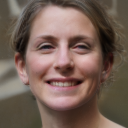

In [11]:
tri_img = eg3d.render_planes(triplanes.to('cuda'), None, reshape_planes=True)[0].cpu().detach().numpy()
tri_img = Image.fromarray(((tri_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(tri_img)

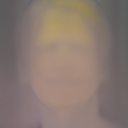

In [12]:
with torch.no_grad():
    out = aec(triplanes.to('cuda'))[0]
ae_img = eg3d.render_planes(out, None, reshape_planes=True)[0].cpu().detach().numpy()
ae_img = Image.fromarray(((ae_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(ae_img)

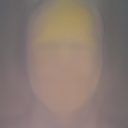

In [13]:
with torch.no_grad():
    posterior = aec.encode(dataset[0]['triplanes'].unsqueeze(0).to('cuda'))
    z = posterior.mode()
    dec = aec.decode(z)
ae_img = eg3d.render_planes(dec.to('cuda'), None, reshape_planes=True)[0].cpu().detach().numpy()
ae_img = Image.fromarray(((ae_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(ae_img)

In [4]:
from diffusers import UNet2DConditionModel

2023-03-09 21:24:26.849303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 21:24:26.931038: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
diffuser = UNet2DConditionModel(
    sample_size=128,
    in_channels=96,
    out_channels=96,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 256, 256),  # the number of output channes for each UNet block
    down_block_types = ('CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D'),
    up_block_types = ('UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D'),
)

In [ ]:
diffuser(dataset[0]['triplanes'].unsqueeze(0), 1, torch.tensor([10, 11, 12]))

In [7]:
diffuser = diffuser.to('cuda')

In [ ]:
out = diffuser(torch.zeros(1, 96, 256, 256).to('cuda'), 1, torch.zeros((1,1,1280)).to('cuda')).sample
out

In [10]:
lf = torch.nn.SmoothL1Loss()
lf(out, torch.ones(out.shape, device='cuda')).backward()


In [5]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

2023-03-17 21:35:55.068755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 21:35:55.151997: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
repo_id = "stabilityai/stable-diffusion-2-base"
# repo_id = "stabilityai/stable-diffusion-x4-upscaler"
pipe = DiffusionPipeline.from_pretrained(repo_id)#, torch_dtype=torch.float16, revision="fp16")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/korte/micromamba/envs/eg3d/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [28]:
pipe.unet.block_out_channels

[320, 640, 1280, 1280]

In [29]:
pipe.unet.sample_size

64

In [14]:
pipe.vae.decoder

Decoder(
  (conv_in): Conv2d(4, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up_blocks): ModuleList(
    (0): UpDecoderBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
          (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
          (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()

In [34]:
pipe.vae.encode(torch.zeros((1, 3, 512, 512),)).latent_dist

In [6]:
pipe.vae.decode(torch.zeros((1, 4, 64, 64))).sample[0][0][0][0]

tensor(0.0427, grad_fn=<SelectBackward0>)

In [12]:
from diffusers import AutoencoderKL
vae = AutoencoderKL(in_channels=96, latent_channels=128, out_channels=96)
vae = vae.to('cuda')

In [13]:
out = vae.encode(dataset[0]['triplanes'].unsqueeze(0).to('cuda'))

In [8]:
out

AutoencoderKLOutput(latent_dist=<diffusers.models.vae.DiagonalGaussianDistribution object at 0x154fc5eacca0>)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
f0 = nn.Linear(5, 5)

f1 = nn.Linear(5, 5)
out = f1(f0(torch.zeros(1, 5)))

f2 = nn.Linear(5, 5)
out2 = f2(f0(torch.zeros(1, 5)))

loss = F.mse_loss(out, torch.zeros(1, 5))
loss.backward()

loss2 = F.mse_loss(out2, torch.zeros(1, 5))
loss2.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.